 <img src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png"  width="300" height="300" /> 
    
    
#### <center>  Simulación de Procesos Financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Daniela Michel Mercado  
**Expedientes:** 723489 y 724506  
**Profesor:** Oscar David Jaramillo Zuluaga.  
**Link Github**: https://github.com/danielamichel/Proyecto1_DMichel_ADurrmuller

#### <center> Proyecto TEMA-2 


#### <center> <font color='red'> 1.1 COVID-19    
<img src="https://www.paho.org/sites/default/files/styles/max_1500x1500/public/hero/2020-03/covid-19-1190x574-2-full.jpg?itok=ZtEWNGB3" width="400" height="400" />

#### <center> 1.2 Objetivos 
 **Objetivo General**: A lo largo de este proyecto se pretende predecir el comportamiento a futuro del virus COVID-19 tomando en cuenta las variables seleccionadas.
    
> **Objetivos Especificos**:
- Encontrar la probabilidad de morir en caso de ser positivo. 
- Encontrar la probabilidad de ser positivo si te haces una prueba.
- Encontrar la probabilidad de recuperarse en caso de ser positivo.

#### <center> 1.3 Definición del Problema.
> El COVID‑19 es la enfermedad infecciosa causada por el coronavirus que se ha descubierto más recientemente. Tanto este nuevo virus como la enfermedad que provoca eran desconocidos antes de que estallara el brote en Wuhan (China) en diciembre de 2019. Actualmente la COVID‑19 es una pandemia que afecta a muchos países de todo el mundo.

#### <center> 1.4 Nodos y Variables que se decidieron simular y porqué

> Los nodos que tomaremos para la simulacion de nuestro proyecto son:
- Casos nuevos
- Muertes nuevas
- Pruebas realizadas
- % pruebas positivas

>Tomamos estas variables porque son las mas representativas para hacer la simulación y poder comparar resultados entre Canadá e Italia.

>Los positivos debido a que son la cantidad de personas infectadas. 
Los recuperados son las personas que se recuperaron y sobrevivieron al virus.
Los test para saber el control de las personas que SI se diagnosticaron a pesar de su sintomatología.
Los fallecidos que nos indica la mortalidad del virus.


#### <center> 1.5 Definición de hipótesis y supuestos.

•El modelo a realizar únicamente es funcional si y solo sí se predicen o interpretan información o datos a nivel mundial agrupado por contiente.

• Se va a tomar como el día más reciente el último dato que tiene el dataframe, el dataframe va de enero a julio del 2020.

• Las variables a modelar son las más significativas para predecir la información más importante del impacto del virus y su comportamiento.

• Los datos que se encuentran en el Data Frame no tienen algun tipo de sesgo o fallo, son correctos


#### <center> 1.6 Obtención de base de datos
(https://www.kaggle.com/josephassaker/covid19-global-dataset?select=worldometer_coronavirus_summary_data.csv)
La base de datos fue obtenida de la página kaggle, es interesante el tema porque es una situación que estamos viviendo en la actualidad.
    

<img src=" file:///Users/ana/Desktop/Proyecto%20SDPF.jpg" >


#### <center> Diagrama
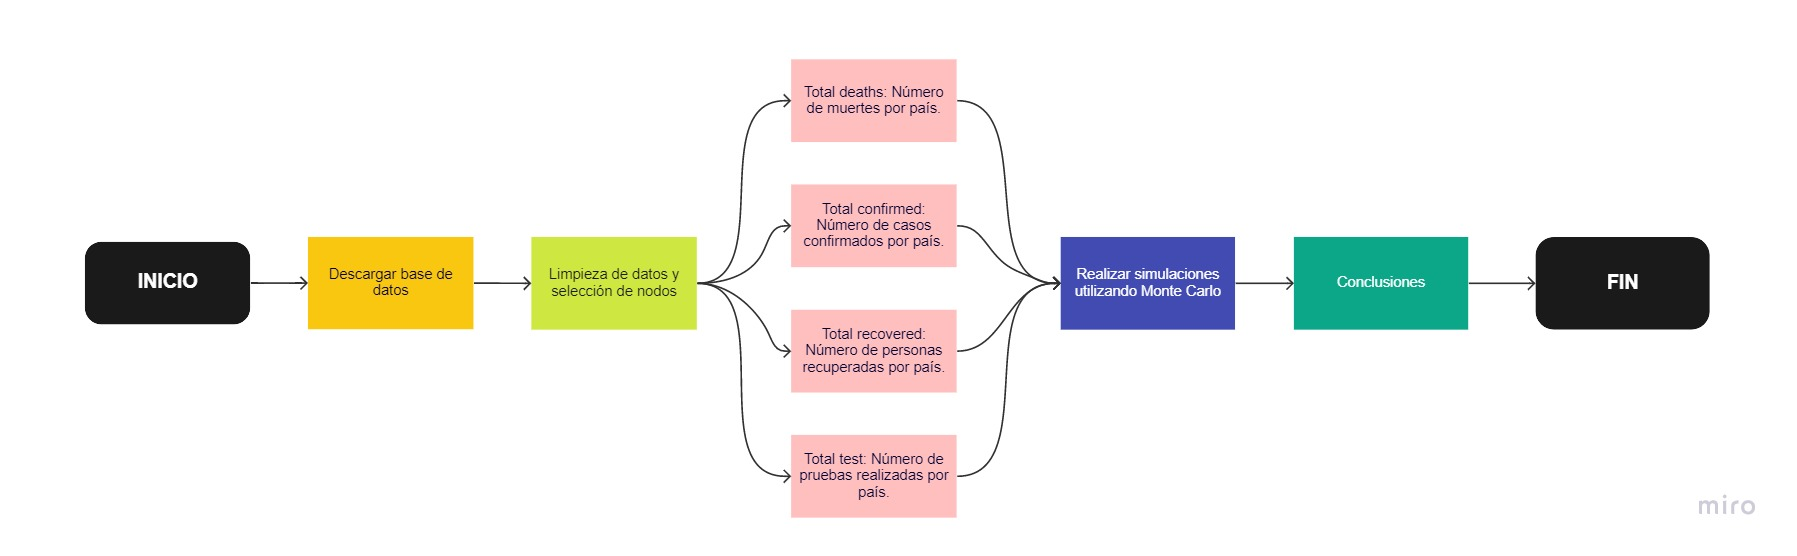
 

## <center> Base de datos

In [2]:
# Importacion de todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import optimize
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [70]:
# Lectura de Data Frame
data = pd.read_csv('./cases_deaths_data.csv')
data = data[(data.iso_code == 'ITA') | (data.iso_code == 'CAN')]

83915

## <center> Limpieza de datos

In [52]:
clean_data = data.loc[:, ['iso_code', 'date', 'new_cases', 'new_deaths', 'total_tests', 'positive_rate']]
clean_data.date = pd.to_datetime(clean_data.date)

# llenar valores nulos
clean_data.new_deaths.fillna(0, inplace=True)

# Mostrar la cola del data framex
clean_data.sample(10)

,iso_code,date,new_cases,new_deaths,total_tests,positive_rate
58552,ITA,2020-12-09,12755.0,499.0,23504588.0,0.110
20848,CAN,2020-05-27,878.0,94.0,1501086.0,0.036
20862,CAN,2020-06-10,495.0,35.0,2013633.0,0.015
21081,CAN,2021-01-15,6844.0,170.0,19713708.0,0.058
58827,ITA,2021-09-10,5617.0,62.0,86852737.0,0.019
58616,ITA,2021-02-11,15137.0,391.0,35384786.0,0.048
58526,ITA,2020-11-13,40902.0,550.0,18455416.0,0.163
20957,CAN,2020-09-13,513.0,3.0,6966164.0,0.011
20861,CAN,2020-06-09,489.0,34.0,1986224.0,0.016
21340,CAN,2021-10-01,5794.0,60.0,43456266.0,0.041


## <center> Funciones a utilizar

In [83]:
def kde(x, bandwidth = 1, **kwargs):
    """Kernel Density Estimation with Scikit-learn when optimal bandwidth is known"""
    if bandwidth == -1:
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 30)},
                    cv=20) # 20-fold cross-validation
        grid.fit(x[:, None])
        bandwidth = grid.best_params_['bandwidth']
        print(bandwidth)
    rng = max(x) - min(x)
    x_grid = np.linspace(min(x)-rng*0.05,max(x)+rng*0.05, 500)
    
    
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return x_grid, np.exp(log_pdf)

def kde_pdf(x, kde):
    return np.exp(kde.score_samples(x.reshape(-1, 1)))

def muestreo_estratificado(n):
    U2 = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (U2 + i)/n

def aceptacion_rechazo(data, f, t, N, kde):
    R2 = muestreo_estratificado(N*10)
    np.random.shuffle(R2)
    ct = 0
    i = 0
    var_acept = np.zeros(N)
    while ct < N:
        R1 = np.random.uniform(min(data), max(data), 1)
        f_x = f(R1, kde)
        t_x = t(R1)
        condition = R2[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = R1[0]
            ct += 1
        i += 1
    return var_acept
    
#Observación gráfica, selección de distribución óptima
def best_fit_params(variable: "Variable aleatoria a ajustar"):
    """
    Función de ajuste para distribución óptima de variables aleatorias.
    Esta función recibe sólo una variable, "variable", la cuál es una de las variables aleatorias
    utilizadas en este proyecto.
    Crea un sample de la variable aleatoria para evitar tener que trabajar con todos los datos,
    esta sample se almacena en la variable datos. Luego, genera un histograma del sample para dar
    una idea de como se ve la variable aleatoria. Se almacena en la variable x el eje x del
    histograma. Se crea una variable llamada dist, que consiste en una lista de las primeras
    50 distribuciones continuas en la librería stats de scipy, además de la variable de
    referencia normal. Se crea un dataFrame de error para registrar el error cuadrático promedio.
    Se itera sobre la lista de distribuciones, se encuentra el error y se almacena en el dataFrame.
    Ordena el dataframe de menor a mayor, se almacena un slice de los primeros 5 valores y se 
    crea una lista de estas distribuciones. Por último, itera sobre el slice de los 5 valores,
    y grafica las funciones de densidad de probabilidad sobre el histograma para mostrar el 
    resultado. Se almacenan los parámetros de estas funciones en una lista.
    Esta función regresa la distribución con menor error y sus parámetros, en dos variables.
    (distribucion, parametros = best_fit_params(variable))
    """
    datos = variable
    y,x,_ = plt.hist(datos,bins="auto",density=True)
    x = x[1:]
    dist = [d for d in dir(st) if isinstance(getattr(st,d),getattr(st,"rv_continuous"))]
    dist = dist[0:50] + ["norm"]
    error = pd.DataFrame(index = dist, columns=["error"])
    for d in dist:
        params = getattr(st,d).fit(datos)
        y_hat = getattr(st,d)(*params).pdf(x)
        error.loc[d] = ((y - y_hat)**2).mean()
    menor_error = error.sort_values(by="error")
    menor_error = menor_error[0:5]
    dists_menor_error = menor_error.index
    distribucion_menor_error = []
    parametros = []
    for d in dists_menor_error:
        distribucion_menor_error.append(getattr(st,d))
        params = getattr(st,d).fit(datos)
        y_hat = getattr(st,d)(*params).pdf(x)
        parametros.append(params)
        plt.plot(x,y_hat,label=d)
    plt.legend()
    return distribucion_menor_error[0], parametros[0]


# Transformada inversa
def trans_inversa(dist, params, size):
    y_hat = dist.rvs(*params,size)
    return y_hat


# Prueba cuantil cuantil
def qq(var: "Variable a comprobar",dist: "Distribución a comprobar",params: "Parámetros distribución"):
    """
    Función qq. Prueba cuantil cuantil. Esta función crea el plot de la prueba cuantil cuantil,
    ("qq"), para la variable dada y la distribución dada. La variable debe ser la colección de 
    frecuencias de una variable aleatoria generada. La distribución debe ser dada por la librería
    Stats de Scipy. No regresa valores. Grafica el plot de la prueba qq.
    """
    fig, ax = plt.subplots(2,1)
    y,x,_ = ax[0].hist(var,bins="auto",density=True)
    x = x[:-1]
    y2 = dist.pdf(x,*params)
    ax[0].plot(x,y,"g--")
    ax[0].set_ylabel("Probabilidad")
    import statsmodels.api as sm
    sm.qqplot(var,dist=dist,line="q",fit=True,ax=ax[1])
    plt.grid()
    ax[1].set_ylabel("Cuantiles")
    
#Chi cuadrada    
def chi2(dist: "Distribución a probar",param: "Parámetros",y: "Frecuencias",x:"Histograma"):
    """
    Prueba de Chi Cuadrada. Esta función realiza la prueba de chi cuadrada para una distribución
    dada, con parámetros dados, y el histograma de la distribución obtenido. Obtiene la función
    de distribución de probabilidad de la distribución dada, y calcula el estadístico de Chi2
    para poder determinar si se acepta o se rechaza la Hipótesis Nula. Calcula los grados de 
    libertad en base a la longitud de datos recibidos del histograma. No regresa valores.
    """
    J = len(x)
    pi = dist.pdf(x,*param)
    #Cálculo de Esperanza de la distribución teórica
    Ei = x*pi
    #Cálculo teórico de la chi2
    chi2 = ((y - Ei)**2 / Ei).sum()
    print("Valor teórico de Chi2 =",chi2)
    #Cálculo mediante librería de chi2
    CHI2 = st.chisquare(y,Ei)
    print("Valor por librería de Chi2 =",CHI2)
    #Grados de libertad
    m = J-1
    #Obtención del estadístico de Chi2
    Chi_st = st.chi2.ppf(q=0.95,df=m)
    print("Estadístico de Chi2 =", Chi_st)   

def prueba_k(var,dist,p):
    d, pvalor = st.kstest(var,lambda x: dist.cdf(x,*p))
    #Confianza al 95%
    if pvalor < 0.05:
        print("No se ajusta a una...")
    else:
        print("Se puede ajustar a una...")

## <center> Nodos de "Casos nuevos"


## <center> Nodo 1: Italia

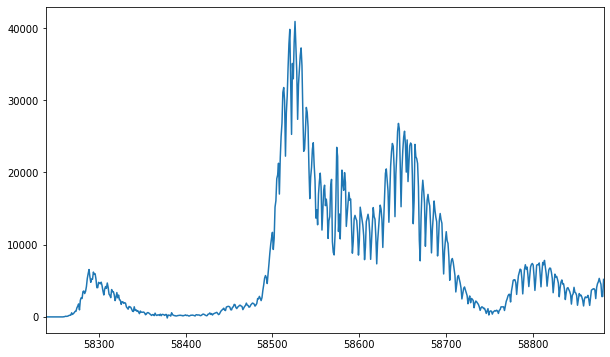

In [73]:
clean_data[clean_data.iso_code == 'ITA']['new_cases'].plot(figsize=(10,6))

In [74]:
# nombrar variable que contenga datos del df determinados

casos_totales = clean_data[clean_data.iso_code == 'ITA']['new_cases'].pct_change().dropna()
casos_totales = casos_totales[(casos_totales <= 1) & (casos_totales >= -1)]

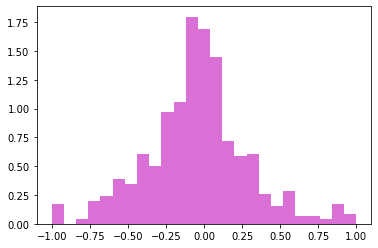

In [58]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales, bins="auto", density = True, color= "orchid"); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_dist

C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 141.67745569229763.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 141.5707924974231.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 141.97899926037348.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 142.82016638258114.
  RuntimeWarning)
C:\Users\dmich\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the

C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
C:\Users\dmich\Anaconda3\lib\site-pack

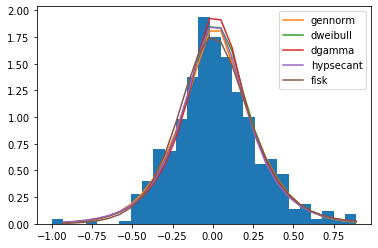

In [77]:
dist, p = best_fit_params(casos_totales)

#### Si es gennorm

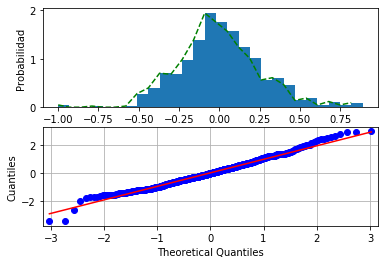

In [79]:
qq (casos_totales, dist, p)

#### Se ajusta bien excepto en las colas

In [81]:
chi2(dist, p, freq, x_hist)

Valor teórico de Chi2 = -32.73637875889474
Valor por librería de Chi2 = Power_divergenceResult(statistic=-32.73637875889474, pvalue=1.0)
Estadístico de Chi2 = 36.41502850180731


#### El pvalue  es superior a nuestro valor de confianza por lo que si se ajusta.

In [84]:
prueba_k (casos_totales, dist, p)

Se puede ajustar a una...


#### Si se puede ajustar a una variable normal 

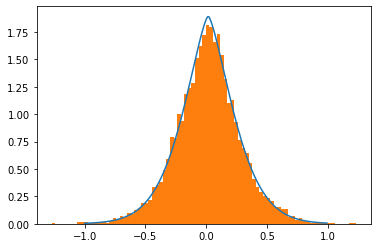

In [100]:
var_a_ajustada = trans_inversa(dist, p, 1000)
dom = np.arange(-1,1,0.01)
plt.plot(dom, dist(*p).pdf(dom))
plt.hist(var_a_ajustada, bins="auto", density=True)
plt.show()

0.11241379310344828


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


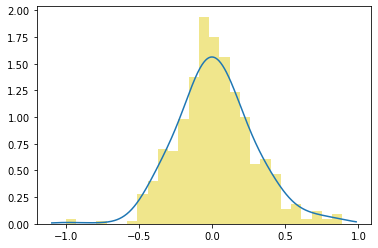

In [101]:
x, pdf = kde(casos_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(casos_totales.values, bins="auto",density=True, color="khaki")
plt.show()

In [17]:
kde_casos = KernelDensity(bandwidth=0.11241379310344828)
kde_casos.fit(casos_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


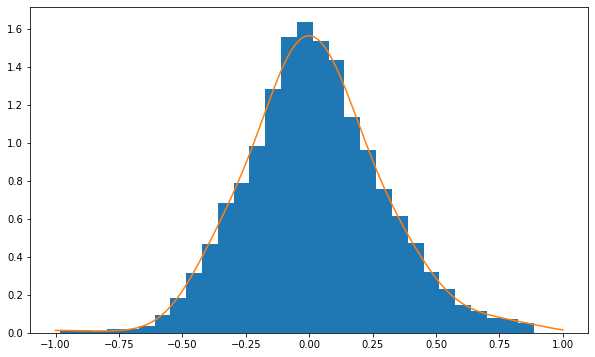

In [18]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_casos)
plt.show()

In [102]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_a_ajustada.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

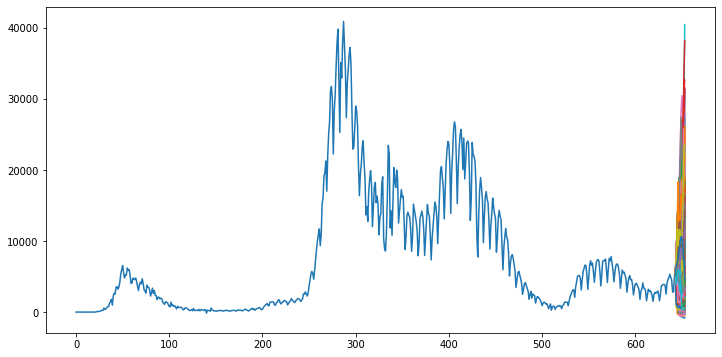

In [103]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

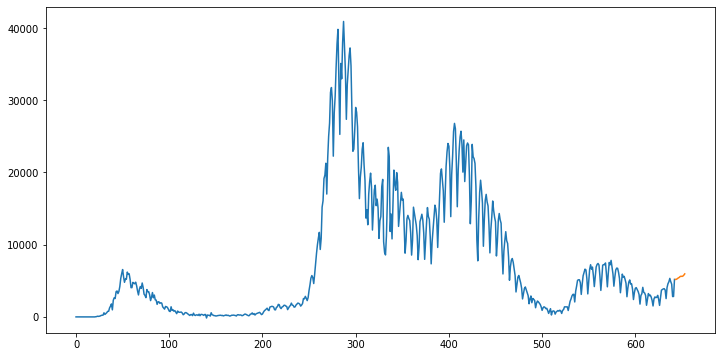

In [104]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

### Canadá

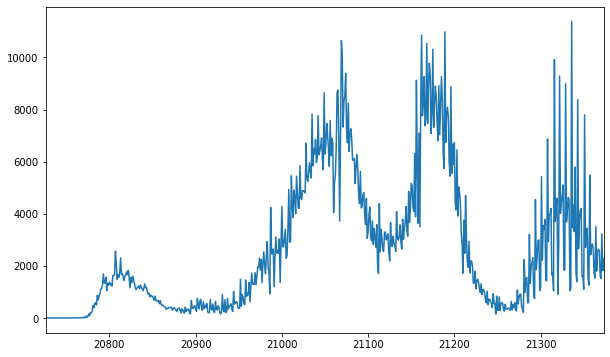

In [23]:
clean_data[clean_data.iso_code == 'CAN']['new_cases'].plot(figsize=(10,6))

In [24]:
# nombrar variable que contenga datos del df determinados

casos_totales = clean_data[clean_data.iso_code == 'CAN']['new_cases'].pct_change().dropna()
casos_totales = casos_totales[(casos_totales <= 1) & (casos_totales >= -1)]

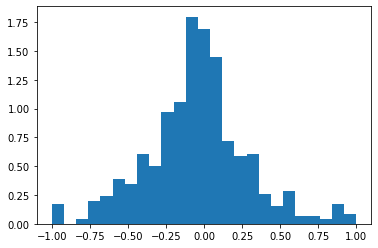

In [25]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales, bins="auto", density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

0.14655172413793105


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


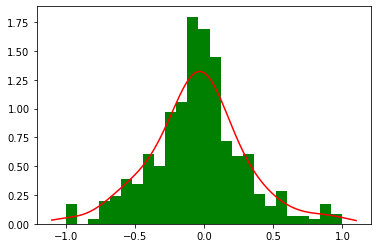

In [26]:
x, pdf = kde(casos_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf, color= 'red')
plt.hist(casos_totales.values, bins="auto",density=True,color='Green')
plt.show()

In [27]:
kde_casos = KernelDensity(bandwidth=0.14655172413793105)
kde_casos.fit(casos_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


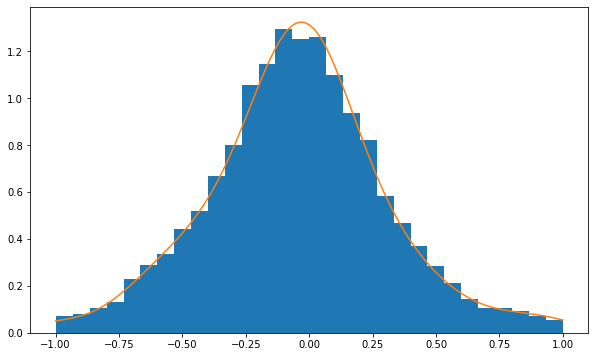

In [28]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_casos)
plt.show()

In [29]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

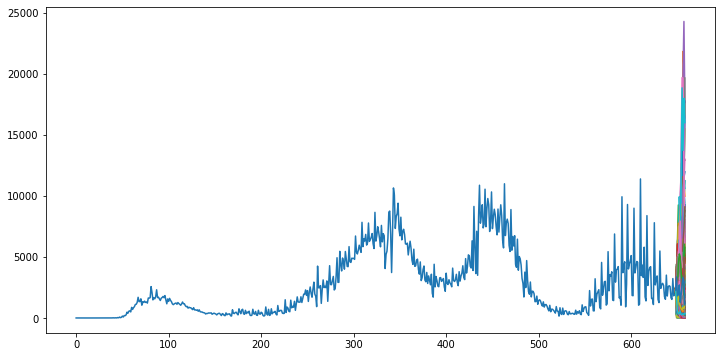

In [30]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

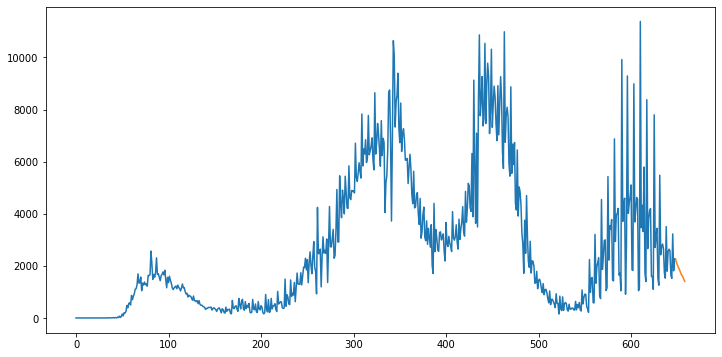

In [31]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

### <center>Muertes</center>

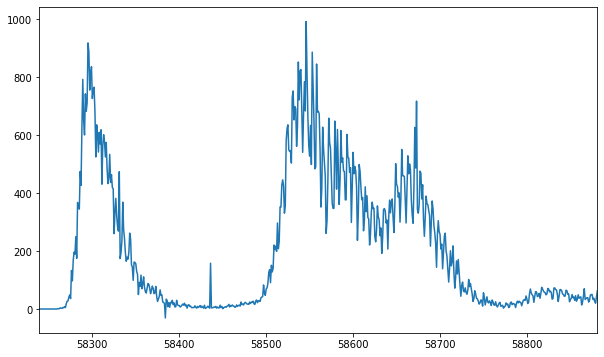

In [32]:
clean_data[clean_data.iso_code == 'ITA']['new_deaths'].plot(figsize=(10,6))

In [34]:
# nombrar variable que contenga datos del df determinados

muertes_totales = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].pct_change().dropna()
muertes_totales = muertes_totales[(muertes_totales <= 1) & (muertes_totales >= -1)]

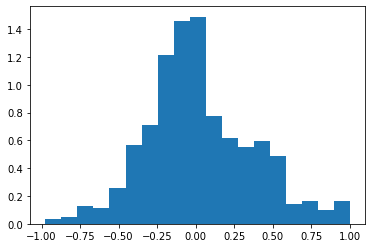

In [35]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_totales, bins="auto", density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

0.07827586206896552


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


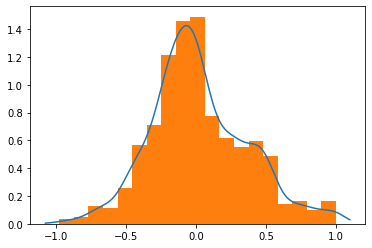

In [36]:
x, pdf = kde(muertes_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(muertes_totales.values, bins="auto",density=True)
plt.show()

In [37]:
kde_muertes = KernelDensity(bandwidth=0.07827586206896552)
kde_muertes.fit(muertes_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_muertes = kde_pdf(x_grid[:, None], kde_muertes)

var_aleatorias = aceptacion_rechazo(muertes_totales.values, kde_pdf, lambda x: max(pdf_muertes) * np.ones(len(x)), 10000, kde_muertes)


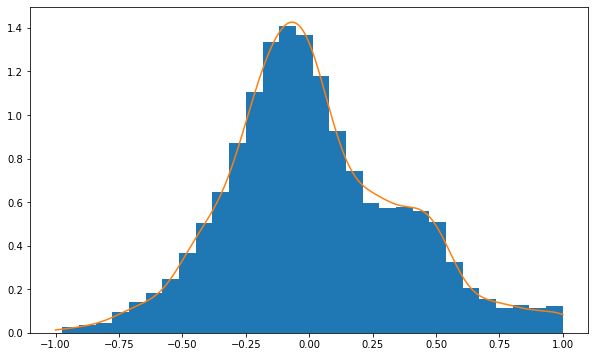

In [38]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_muertes)
plt.show()

In [39]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].values[-1]
dias_a_sim = 10
muertes_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(muertes_sim)):
    muertes_sim[i][0] = ultimo_valor * (1 + muertes_sim[i][0])
    for j in range(1, dias_a_sim):
        muertes_sim[i][j] = muertes_sim[i][j-1] * (1 + muertes_sim[i][j])

    

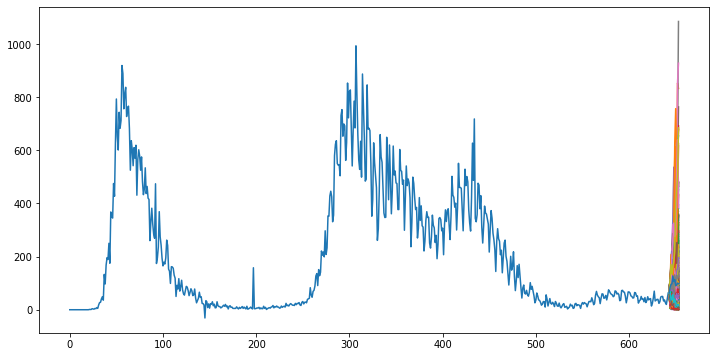

In [40]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_deaths'])
for i in range(len(muertes_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim[i]))
plt.show()

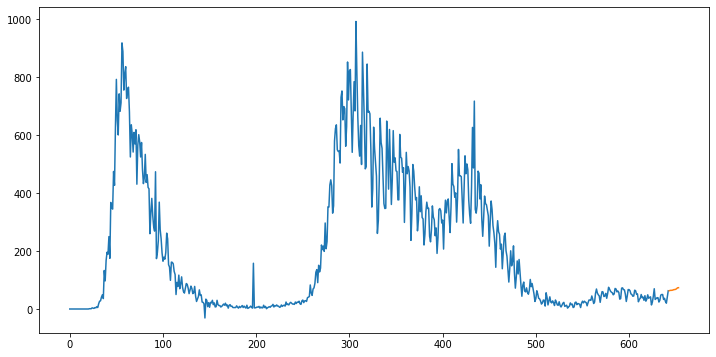

In [41]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_deaths'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim.mean(axis=0)))
plt.show()

### Canadá

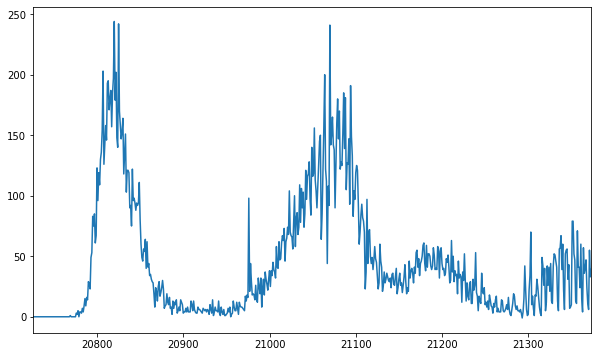

In [42]:
clean_data[clean_data.iso_code == 'CAN']['new_deaths'].plot(figsize=(10,6))

In [43]:
# nombrar variable que contenga datos del df determinados

muertes_totales = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].pct_change().dropna()
muertes_totales = muertes_totales[(muertes_totales <= 1) & (muertes_totales >= -1)]

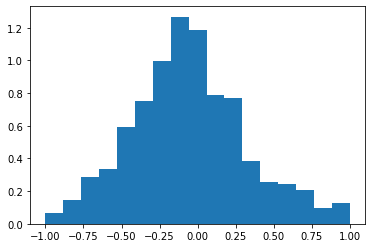

In [44]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_totales, bins="auto", density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

0.11241379310344828


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


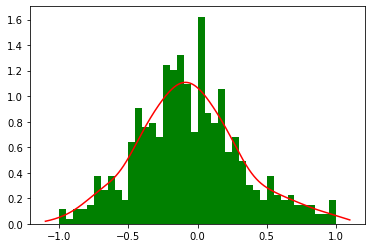

In [45]:
x, pdf = kde(muertes_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf, color= 'red')
plt.hist(muertes_totales.values, bins=40,density=True,color='Green')
plt.show()

In [46]:
kde_muertes_c = KernelDensity(bandwidth=0.11241379310344828)
kde_muertes_c.fit(muertes_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_muertes_c = kde_pdf(x_grid[:, None], kde_muertes_c)

var_aleatorias = aceptacion_rechazo(muertes_totales.values, kde_pdf, lambda x: max(pdf_muertes_c) * np.ones(len(x)), 10000, kde_muertes_c)


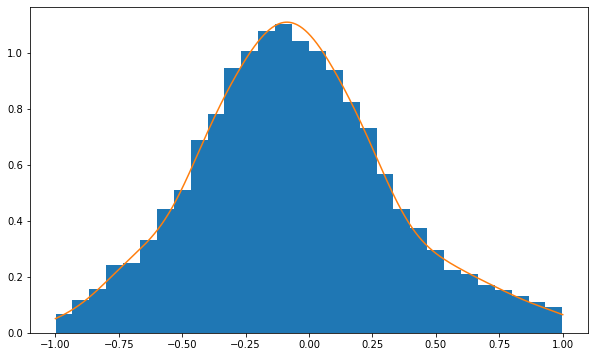

In [47]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_muertes_c)
plt.show()

In [48]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].values[-1]
dias_a_sim = 10
muertes_sim_c = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(muertes_sim_c)):
    muertes_sim_c[i][0] = ultimo_valor * (1 + muertes_sim_c[i][0])
    for j in range(1, dias_a_sim):
        muertes_sim_c[i][j] = muertes_sim_c[i][j-1] * (1 + muertes_sim_c[i][j])

    

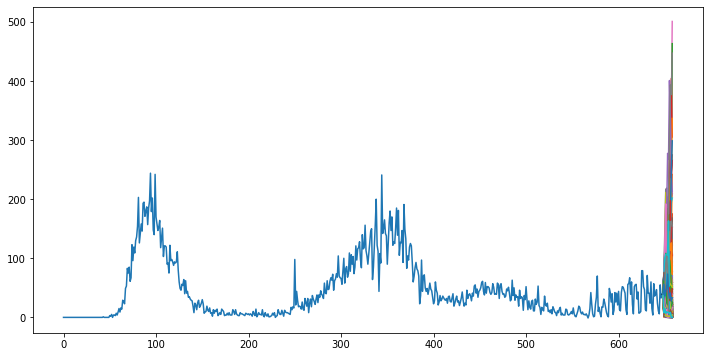

In [49]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_deaths'])
for i in range(len(muertes_sim_c)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim_c[i]))
plt.show()

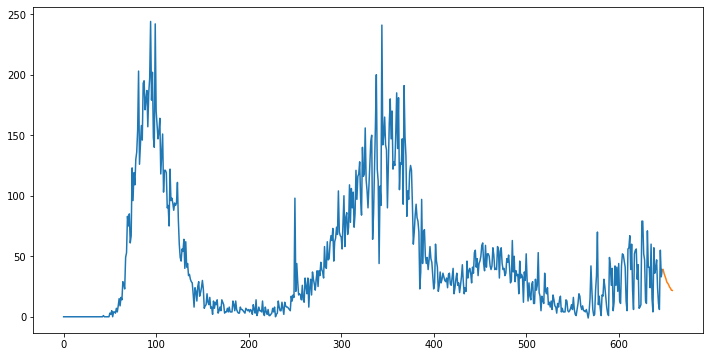

In [50]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_deaths'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim_c.mean(axis=0)))
plt.show()